# Higgs Challenge - Jan

* [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

## ToDo list
* check XGBoostClassifier
* grid search using full dataset with XGBoostClassifier
* p<sub>x,y,z</sub> projections?

## Initialisation

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas
import pandas as pd
import numpy
import numpy as np

import root_numpy

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from rep.estimators import XGBoostClassifier

from bayes_opt import BayesianOptimization

Welcome to ROOTaaS 6.06/04


### Download data

In [2]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root
!cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

File `public_train_10000.root' already there; not retrieving.
File `public_train_100000.root' already there; not retrieving.
File `public_test.root' already there; not retrieving.


### Read the training files and the test file
* `data` holds the small training data set
* `full_data` holds the full training data set
* `test` holds the test data set

In [2]:
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
full_data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_100000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

data.head(2)

,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,...,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,...,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559


## Utility functions for feature engineering

In [3]:
def dphi(phi1, phi2):
    "Return the angular difference in the range [-pi,pi)"
    dphi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return dphi

def dr(eta1, eta2, phi1, phi2):
    "Return the eta-phi distance"
    return np.sqrt((eta1-eta2)**2 + dphi(phi1,phi2)**2)

## Define training features

### Existing features

In [4]:
features = list(set(data.columns) - {'event_id', 'target'})
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

# a list of all proper objects and all objects + MET
real_objects = ['lepton', 'jet1', 'jet2', 'jet3', 'jet4']
objects = real_objects + ['mem']

### Define additional features

#### Additional feature ideas
--

In [5]:
def add_features(data):
    data['ht'] = data['jet1_pt'] + data['jet2_pt'] + data['jet3_pt'] + data['jet4_pt']
    data['meff'] = data['jet1_pt'] + data['jet2_pt'] + data['jet3_pt'] + data['jet4_pt'] + data['lepton_pt'] + data['mem_pt']
    data['rt'] = data['meff'] / data['m_wwbb']
    data['delta_m'] = np.abs(data['m_jjj'] - data['m_jlv'])
    
    variables = ['ht', 'meff', 'rt', 'delta_m']
    
    data['dr_j12'] = dr(data['jet1_eta'], data['jet2_eta'], data['jet1_phi'], data['jet2_phi'])
    data['dr_j34'] = dr(data['jet3_eta'], data['jet4_eta'], data['jet3_phi'], data['jet4_phi'])
    
    variables += ['dr_j12', 'dr_j34']
    
    for i in [1,2,3,4]:
        data['dr_lj%d' % i] = dr(data['jet%d_eta' % i], data['lepton_eta'], data['jet%d_phi' % i], data['lepton_phi'])
        data['dphi_met_j%d' % i] = np.abs(dphi(data['mem_phi'], data['jet%d_phi' % i]))

        variables += ['dr_lj%d' % i, 'dphi_met_j%d' % i]
        
    data['max_dr_lj'] = np.maximum(np.maximum(data['dr_lj1'], data['dr_lj2']),
                                   np.maximum(data['dr_lj3'], data['dr_lj4']))
    data['min_dr_lj'] = np.minimum(np.minimum(data['dr_lj1'], data['dr_lj2']),
                                   np.minimum(data['dr_lj3'], data['dr_lj4']))   

    data['max_dphi_met_j'] = np.maximum(np.maximum(data['dphi_met_j1'], data['dphi_met_j2']),
                                        np.maximum(data['dphi_met_j3'], data['dphi_met_j4']))
    data['min_dphi_met_j'] = np.minimum(np.minimum(data['dphi_met_j1'], data['dphi_met_j2']),
                                        np.minimum(data['dphi_met_j3'], data['dphi_met_j4']))

    variables += ['max_dr_lj', 'min_dr_lj', 'max_dphi_met_j', 'min_dphi_met_j']

    data['max_jet_pt'] = np.maximum(np.maximum(data['jet1_pt'], data['jet2_pt']),
                                    np.maximum(data['jet3_pt'], data['jet4_pt']))
    data['min_jet_pt'] = np.minimum(np.minimum(data['jet1_pt'], data['jet2_pt']),
                                    np.minimum(data['jet3_pt'], data['jet4_pt']))       
    
    variables += ['max_jet_pt', 'min_jet_pt']
    
    for obj in real_objects:
        data['%s_abs_eta' % obj] = np.abs(data['%s_eta' % obj])
        variables.append('%s_abs_eta' % obj)
        
        for obj2 in ['lepton']:
            if obj == obj2:
                continue
            
            dphi_name = "dphi_%s_%s" % (obj, obj2)
            deta_name = "deta_%s_%s" % (obj, obj2)
            
            data[dphi_name] = np.abs(dphi(data['%s_phi' % obj], data['%s_phi' % obj2]))
            data[deta_name] = np.abs(data['%s_eta' % obj] - data['%s_eta' % obj2])
            
            variables += [dphi_name, deta_name]
    
    return variables

new_features = add_features(data)
add_features(full_data)
add_features(test)

training_data, validation_data = train_test_split(data, random_state=11, train_size=0.8)
full_train, full_valid = train_test_split(full_data, random_state=11, train_size=0.9)

signal = data[data.target == 1]
background = data[data.target == 0]

## Feature distributions

### Utility plotting functions

In [6]:
hist_params = {'normed': True, 'bins': 50, 'alpha': 0.4,}# 'histtype': 'stepfilled'}

def plot_feature(feature):
    plot_range = numpy.percentile(data[feature], [1, 99])
    plt.hist(background[feature].values, range=plot_range, label="background", **hist_params)
    plt.hist(signal[feature].values, range=plot_range, label="signal", **hist_params)
    plt.legend(loc='best')
    plt.title(feature)
    
def plot_value(sig, bkg, title=""):
    sig_val = sig.values
    bkg_val = bkg.values
    
    min_sig, max_sig = numpy.percentile(sig_val, [1, 99])
    min_bkg, max_bkg = numpy.percentile(bkg_val, [1,99])
    
    plot_range = (min(min_sig, min_bkg), max(max_sig, max_bkg))

    plt.figure(figsize=(8, 5))
    plt.hist(bkg_val, range=plot_range, label='background', **hist_params)
    plt.hist(sig_val, range=plot_range, label='signal', **hist_params)
    plt.legend(loc='best')
    plt.title(title)
    
def figure_2d(x, y, *args, **kwargs):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.title("signal")
    plt.hist2d(signal[x], signal[y], *args, **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.subplot(1, 2, 2)
    plt.title("background")
    plt.hist2d(background[x], background[y], *args, **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

def plot_vars(var_list):
    n_cols = 3
    n_rows = len(var_list) // n_cols + 1
    
    plt.figure(figsize=(16, n_rows*5))
    
    for n, var in enumerate(var_list):
        plt.subplot(n_rows, n_cols, n+1)
        plot_feature(var)


### High level features and object p<sub>T</sub>

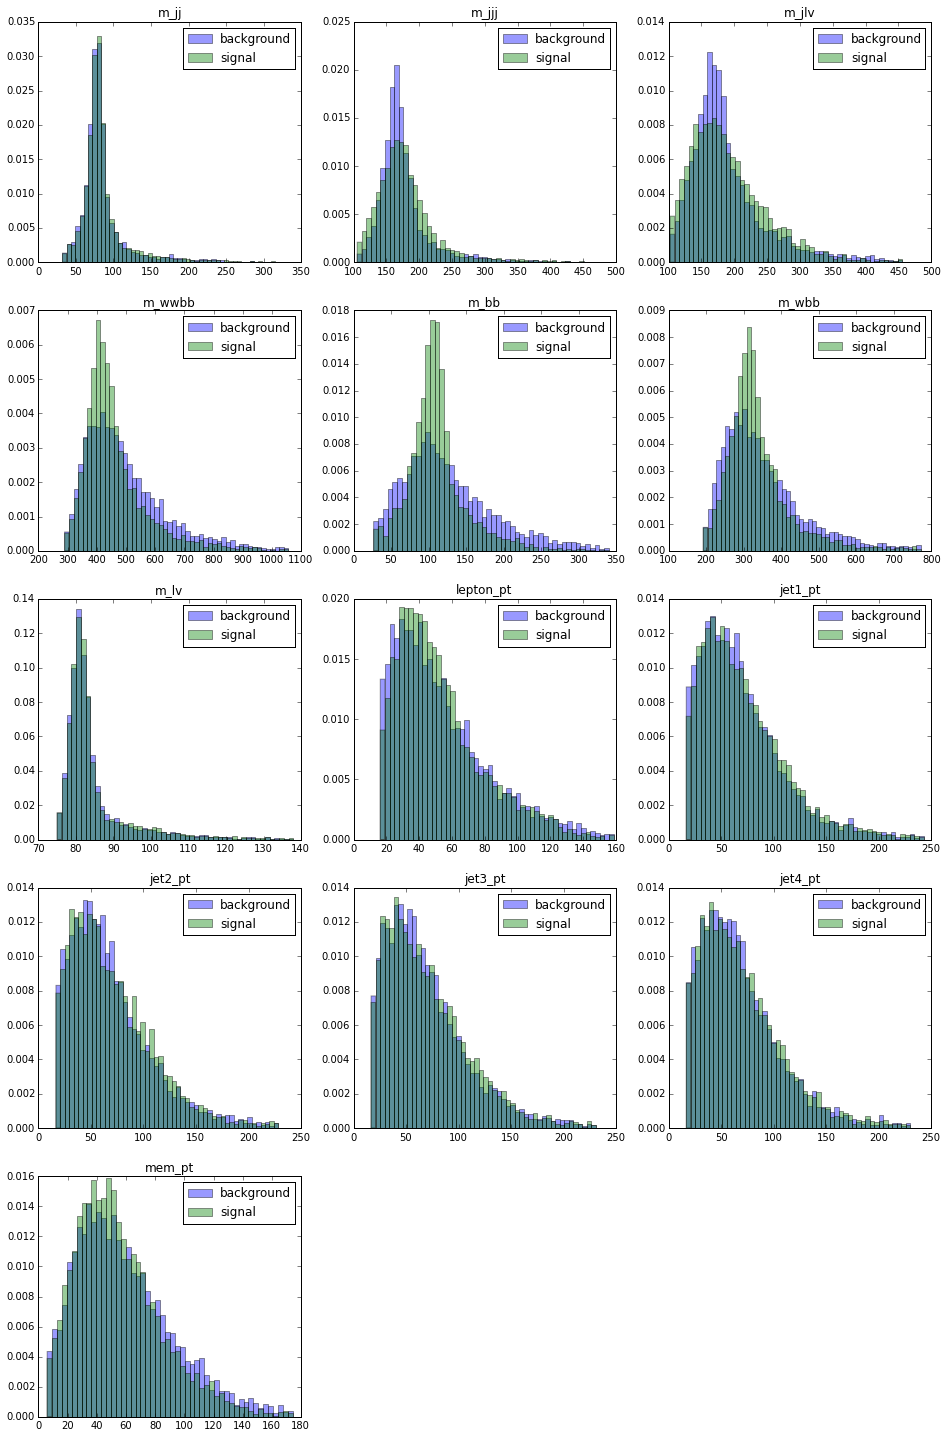

In [23]:
plot_vars(high_level_features + ["%s_pt" % obj for obj in objects])

### New features

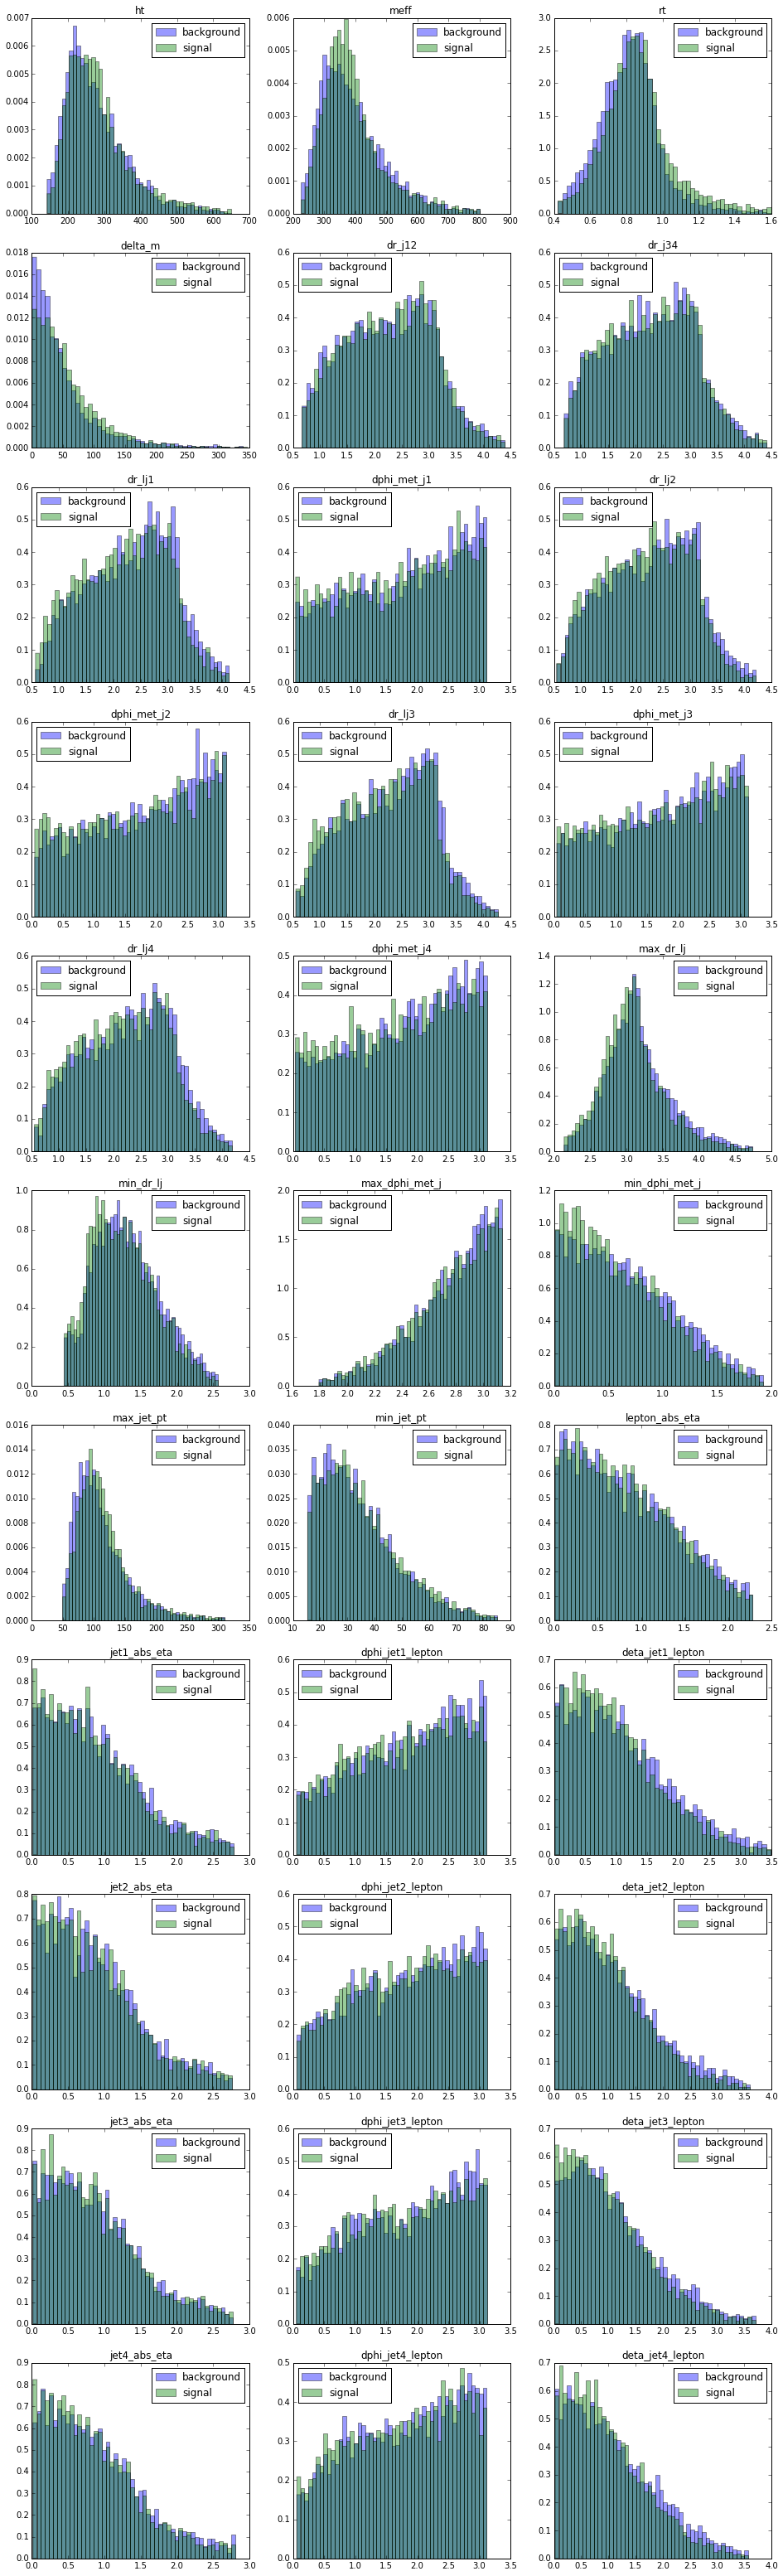

In [18]:
plot_vars(new_features)

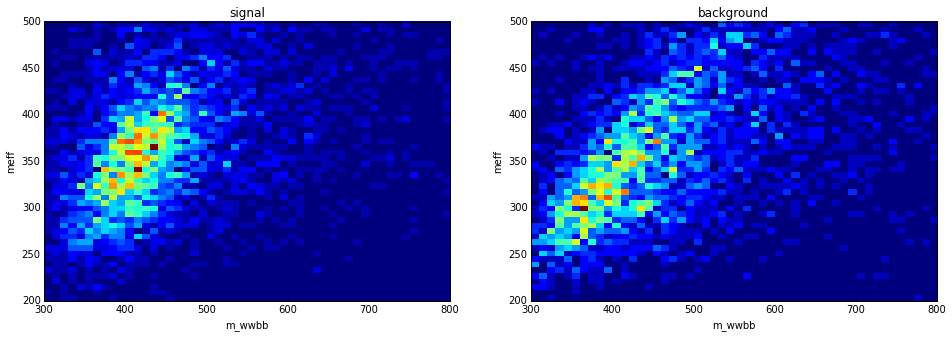

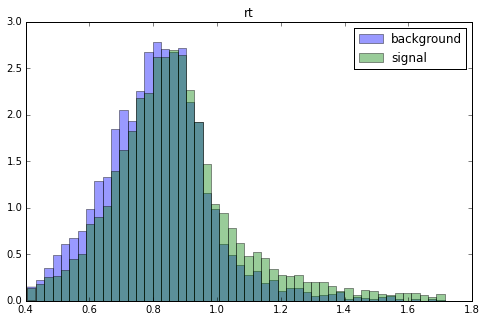

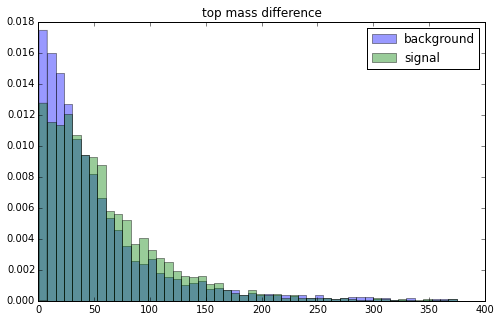

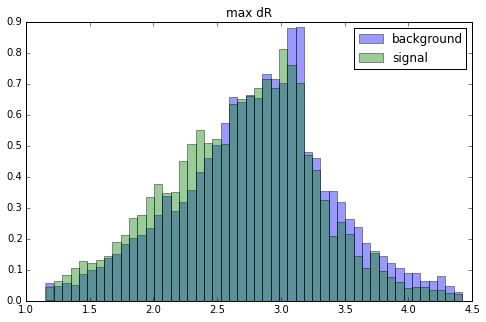

In [54]:
figure_2d("m_wwbb", "meff", range=((300,800), (200, 500)), bins=(50,50))

sig = signal
bkg = background
plot_value(sig["meff"] / sig["m_wwbb"], bkg["meff"] / bkg["m_wwbb"], "rt")
plot_value(np.abs(sig['m_jjj'] - sig['m_jlv']), np.abs(bkg['m_jjj'] - bkg['m_jlv']), "top mass difference")

plot_value(np.maximum(sig['dr_lj1'], sig['dr_lj2']), np.maximum(bkg['dr_lj1'], bkg['dr_lj2']), "max dR")

## Test area

## Cross validation

In [7]:
from sklearn.base import BaseEstimator
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score

class CVEstimator(BaseEstimator):
    def __init__(self, cv, est_type, args={}):
        self.cv = cv
        self.estimator_type = est_type
        self.estimator_args = args
        
        self.estimators = [est_type(**args) for _ in xrange(self.cv)]
        
    def fit(self, x, y):
        skf = StratifiedKFold(y.copy(), self.cv)
        
        self.scores = []
        
        for i, train_test in enumerate(skf):
            est = self.estimators[i]
            train, test = train_test
            
            est.fit(x.iloc[train], y.iloc[train])
            
            pred = est.predict_proba(x.iloc[test])[:,1]
            score = roc_auc_score(y.iloc[test], pred)
            self.scores.append(score)
            
        # calculate feature importance
        score_norm = 1 / sum(self.scores)
        self.feature_importances_ = []
        
        for i in xrange(len(self.estimators[0].feature_importances_)):
            imp_sum = 0
            for j, est in enumerate(self.estimators):
                imp_sum += self.scores[j] * est.feature_importances_[i]
            
            self.feature_importances_.append(imp_sum * score_norm)
        
        return self
    
    def predict_proba(self, x):
        pred = None
        
        for est in self.estimators:
            this_pred = est.predict_proba(x)
            if pred is None:
                pred = this_pred
            else:
                pred += this_pred
        
        pred /= self.cv
        return pred

In [8]:
def check_classifier(features, clf, silent=False, ranking=True, train=training_data, test=validation_data):
    clf.fit(train[features], train.target)
    pred = clf.predict_proba(test[features])
    auc = roc_auc_score(test.target, pred[:,1])
    if not silent:
        print "AUC", auc
    
    if ranking and not silent:
        for name, importance in sorted(zip(features, clf.feature_importances_), key=lambda x: x[1], reverse=True):
            print "%20s  %.4f" % (name, importance)

    return clf, auc

In [21]:
%%time
bad_features = [
    "jet4_btag", 
    "jet3_btag", 
    "jet1_btag",
    "jet2_btag",
    "jet1_eta",
    "jet2_eta",
    "jet3_eta",
    "jet4_eta",
    "lepton_eta",
]

selected_features = features + new_features
selected_features = list(set(selected_features) - set(bad_features))

selected_settings = {'max_depth': 6.5438319838888193, 'gamma': 0.037088211931513702, 'min_child_weight': 5.7748282473162469}

#clf, auc = check_classifier(selected_features, CVEstimator(6, XGBoostClassifier, selected_settings))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.9 µs


In [10]:
def clf_plots(clf, features, data=validation_data, name="Classifier"):
    sig = data[data.target==1]
    bkg = data[data.target==0]
    
    pred_bkg = clf.predict_proba(bkg[features])
    pred_sig = clf.predict_proba(sig[features])
    
    pred = clf.predict_proba(data[features])
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.hist(pred_bkg[:,1], label="background", alpha=.5, color="blue", range=(0,1), bins=30)
    plt.hist(pred_sig[:,1], label="signal", alpha=.5, color="red", range=(0,1), bins=30)
    plt.title(name + " probability")
    plt.legend(loc="best")
    
    fpr, tpr, _ = roc_curve(data.target, pred[:,1])
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr,  label=name)
    plt.plot([0, 1], [0, 1], 'k--', label='')
    plt.xlabel('FPR'), plt.ylabel('FPR')
    plt.legend(loc='best')
    
    plt.show()

In [11]:
clf_plots(clf, selected_features)

NameError: name 'clf' is not defined

## Hyperparameter optimisation

### Grid search to check best settings
* max_depth (3, 10)
* max_features (0.7, 1.0)
* loss {‘deviance’, ‘exponential’},

In [18]:
XGBoostClassifier()

XGBoostClassifier(base_score=0.5, colsample=1.0, eta=0.3, features=None,
         gamma=None, max_depth=6, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=16, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=1.0, verbose=0)



In [27]:
def result_func(max_depth, gamma, min_child_weight, n_estimators, eta):
    settings = {
        'max_depth': max_depth,
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'n_estimators': int(n_estimators),
        'eta': eta,
    }
    
    _, auc = check_classifier(selected_features, XGBoostClassifier(**settings), silent=True, train=full_train, test=full_valid)
    return auc

ranges = {
    'max_depth': (6, 12),
    'gamma': (0.01, 0.1),
    'min_child_weight': (2, 20),
    'n_estimators': (50, 300),
    'eta': (0.1, 0.5),
}

opt = BayesianOptimization(result_func, ranges)
opt.maximize()

print opt.res['max']

# 19 | 00m10s |    0.77375 |    0.0133 |     10.9323 |             9.0753 | 

Initialization
---------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |       eta |     gamma |   max_depth |   min_child_weight |   n_estimators | 
    1 | 17m26s |    0.80333 |    0.1118 |    0.0925 |      8.3390 |             8.0145 |       193.8917 | 
    2 | 02m40s |    0.80001 |    0.1784 |    0.0916 |      8.6987 |             8.3917 |       194.3312 | 
    3 | 03m23s |    0.80088 |    0.1626 |    0.0477 |      8.0309 |            12.0214 |       263.3188 | 
    4 | 02m44s |    0.76736 |    0.4886 |    0.0414 |      9.9416 |            12.9738 |       198.5296 | 
    5 | 02m12s |    0.80520 |    0.1071 |    0.0204 |      7.4357 |             4.3512 |       202.8332 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |       eta |     gamma |   max_depth |   min_child_weight |   n_estimators | 
  

In [28]:
def result_func(max_depth, gamma, min_child_weight, n_estimators, eta):
    settings = {
        'max_depth': max_depth,
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'n_estimators': int(n_estimators),
        'eta': eta,
    }
    
    _, auc = check_classifier(selected_features, XGBoostClassifier(**settings), silent=True, train=full_train, test=full_valid)
    return auc

ranges = {
    'max_depth': (6, 10),
    'gamma': (0.01, 0.1),
    'min_child_weight': (5, 10),
    'n_estimators': (150, 250),
    'eta': (0.02, 0.2),
}

opt = BayesianOptimization(result_func, ranges)
opt.maximize()

print opt.res['max']

Initialization
---------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |       eta |     gamma |   max_depth |   min_child_weight |   n_estimators | 
    1 | 03m07s |    0.80651 |    0.0710 |    0.0120 |      9.2513 |             6.3904 |       179.2221 | 
    2 | 02m11s |    0.80175 |    0.1724 |    0.0686 |      7.4271 |             6.7109 |       153.9222 | 
    3 | 02m14s |    0.80474 |    0.0460 |    0.0821 |      7.0643 |             5.0520 |       170.2766 | 
    4 | 02m51s |    0.80501 |    0.1088 |    0.0840 |      9.8667 |             7.2031 |       171.8335 | 
    5 | 01m54s |    0.80639 |    0.1308 |    0.0225 |      6.9832 |             9.2079 |       183.2152 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |       eta |     gamma |   max_depth |   min_child_weight |   n_estimators | 
  

## Prepare submission to kaggle

### Train final classifier over full dataset and evaluate on test sample

In [29]:
%%time

#selected_settings = {
#    'max_features': 0.8,
#    'max_depth': 6,
#    'n_estimators': 200,
#}
#
#final_clf, final_auc = check_classifier(selected_features, CVEstimator(6, GradientBoostingClassifier, selected_settings),
#                             train=full_train, test=full_valid)
#
# AUC 0.80768877548

selected_settings = {
    'max_depth': 8,
    'gamma': 0.015,
    'min_child_weight': 9,
    'n_estimators': 250,
    'eta': 0.06,
}

final_clf, final_auc = check_classifier(selected_features, CVEstimator(6, XGBoostClassifier, selected_settings),
                             train=full_train, test=full_valid)

test_proba = final_clf.predict_proba(test[selected_features])[:, 1]
test_ids = test.event_id

AUC 0.80995543231
                m_bb  2268.6344
           lepton_pt  2212.3019
               m_jjj  1986.4116
               m_jlv  1965.7051
              m_wwbb  1891.3189
                m_jj  1862.5572
              mem_pt  1808.1783
               m_wbb  1646.1879
          max_jet_pt  1558.6742
           min_dr_lj  1281.3704
             delta_m  1219.2718
                m_lv  1154.2803
                  rt  1144.3247
                  ht  1111.0573
           max_dr_lj  1063.6599
      min_dphi_met_j  1061.1126
                meff  1046.0081
              dr_j12  1042.4317
    deta_jet3_lepton  999.3408
    deta_jet2_lepton  970.2418
              dr_j34  965.0626
          min_jet_pt  951.3533
    deta_jet1_lepton  919.8448
    deta_jet4_lepton  915.6562
        jet4_abs_eta  896.3390
         dphi_met_j2  892.0075
             jet3_pt  876.9529
              dr_lj3  864.8920
             jet2_pt  850.3044
      lepton_abs_eta  840.3355
        jet3_abs_eta  837.7357
   

In [30]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))

In [31]:
create_solution(test_ids, test_proba, 'b_xdg_gridopt.csv')

/home/jan/work/mlhep/mlhep2016/higgs_kaggle/datasets/b_xdg_gridopt.csv